In [1]:
# Most Code here
import sys
#Switch to deepliver
#if "/opt/caffe/python" in sys.path : sys.path.remove("/opt/caffe/python")
#if "/opt/deepliver/python" not in sys.path : sys.path.insert(0,"/opt/deepliver/python")

import plyvel, lutils, math, re
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import pandas
from PIL import Image,ImageFilter
plt.set_cmap('gray')
%matplotlib inline

def hist(arr):
    """Print number of pixels for each label in the given image (arr)"""
    return "%.3f , %.3f , %.3f, %.3f" % (np.sum(arr==0),np.sum(arr==1),np.sum(arr==2),np.sum(arr==4))

def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
        
def dice(prediction, segmentation, label_of_interest = 1):
    """ Takes 2 2-D arrays with class labels, and return a float dice score.
    Only label=label_of_interest is considered """
    if prediction.shape != segmentation.shape:
        raise ValueError("Shape mismatch between given arrays. prediction %s vs segmentation %s" \
                         % (str(prediction.shape), str(segmentation.shape)))

    n_liver_seg = np.sum(segmentation==label_of_interest)
    n_liver_pred= np.sum(prediction == label_of_interest)
    denominator = n_liver_pred + n_liver_seg
    if denominator == 0:
        return -1

    liver_intersection   = np.logical_and(prediction==label_of_interest, segmentation==label_of_interest)
    n_liver_intersection = np.sum(liver_intersection)

    dice_score = 2.0*n_liver_intersection / denominator
    return dice_score

def protobinary_to_array(filename, outpng=None):
    """ Filename is path to protobinary
    outpng is path to output png"""
    with open(filename,'r') as f:
        data = f.read()

    blob = caffe.proto.caffe_pb2.BlobProto()
    blob.ParseFromString(data)
    arr = np.array(caffe.io.blobproto_to_array(blob)) #returns shape (1,1,W,H)
    arr = arr[0,0,:,:] #ignore first 2 dimensions
    return  arr

dices_liver = []
dices_lesion= []
def predict(net, img, seg, meanimg):
    """Predicts an img using the trained net, and compares it to the label image (seg)"""
    net.blobs['data'].data[0]=(img-meanimg)
    prob=net.forward()['prob'][0]
    prediction = np.argmax(prob,axis=0)
    dice_liver = dice(prediction,seg,label_of_interest=1)
    dice_lesion = dice(prediction,seg,label_of_interest=2)
    dices_liver.append(dice_liver)
    dices_lesion.append(dice_lesion)
    print "Dice Liver:", dice_liver
    print "Dice Lesion:",dice_lesion
    print "Prediction class histogram",hist(prediction)
    print "Ground truth class histogram",hist(seg)
    plt.figure(figsize=(20,24))
    plt.subplot(1,3,1); plt.title("Image")
    plt.imshow(img)
    plt.subplot(1,3,2); plt.title("Ground truth")
    plt.imshow(seg)
    plt.subplot(1,3,3); plt.title("Prediction")
    plt.imshow(prediction)
    plt.show()
    
def read_imgs(dbimgit, dbsegit, n=1, print_keys=True):
    """Read img and label after skipping n keys in leveldb. Takes db iterators"""
    for _ in range(n):
        k1,vimg = dbimgit.next()
        k2,vseg = dbsegit.next()
    if print_keys:
        print "Keys:",k1,k2
    img=lutils.to_numpy_matrix(vimg)
    seg=lutils.to_numpy_matrix(vseg)
    return img,seg

def show_kernels(layer_blob_data, fast = False):
    """ Takes solver.net.params['conv1'][0].data and visualize the first channel of all kernels.
    If fast = False : subplots will be used, allowing to see each filter individually, but takes time.
    If fast = True : all filters are plotted in one image"""
    #Input has 4 dims, we only visualize 1st channel of each kernel 
    # (the conv weights that acts on the 1st channel of the input)
    data = layer_blob_data[:,0,:,:]
    if fast:
        raise NotImplementedError("todo")
    n_kernels = data.shape[0]
    plot_cols = 10 #number of images in one row
    plot_rows = math.ceil(n_kernels*1.0 / plot_cols)
    # Adjust figure plot size
    plt.figure(figsize=(min(plot_cols, n_kernels)*2, plot_rows*2))
    # Plot !
    for i in range(n_kernels):
        plt.subplot(plot_rows, plot_cols, i+1)
        plt.imshow(data[i], interpolation='none')
        
def plot_deepliver_log(fname):
    """Takes file handle of deepliver log, and plots the 4 plots :
    Loss, avgAccuracy, avgJaccard, avgRecall"""
    f = open(fname, 'r')
    logs = f.read()
    plt.figure(figsize=(10,10))
    # Get iterations
    iterations = re.findall("Iteration (\d+), loss",logs)

    # Get&plot loss
    loss = zip(*re.findall("Iteration \d+, loss = ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)",logs))[0]
    length = min(len(iterations), len(loss))
    iterations_trunc, loss_trunc = iterations[:length], loss[:length]
    plt.plot(iterations,loss,label='Loss')
    #plt.show()
    #Get&plot metrics
    metrics = ['Accuracy','Recall','Jaccard']
    data = defaultdict(list) # data.keys() = metrics , data[metrics[0]] = list of values
    for i,metric in enumerate(metrics):
        regex = "Train net output #"+str(i)+": accuracy = ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)"
        for result in re.findall(regex,logs):
            data[metric].append(result[0])

    for metric in data.keys():
        length = min(len(iterations),len(data[metric]))
        iterations_trunc, data_trunc = iterations[:length], data[metric][:length]
        plt.plot(iterations_trunc, data_trunc,label=metric)
        plt.legend(loc="lower center",prop={'size':15})
    f.close()


def histeq(im,nbr_bins=256):
    """Histogram equalization"""
    #get image histogram
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() #cumulative distribution function
    cdf = 255 * cdf / cdf[-1] #normalize
    #use linear interpolation of cdf to find new pixel values
    im2 = np.interp(im.flatten(),bins[:-1],cdf)
    return im2.reshape(im.shape)

def imshow_overlay_segmentation(him,img,seg,pred):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(himg)
    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(img); plt.hold(True)
    plt.imshow(seg, cmap="Blues", alpha=0.3)
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(img); plt.hold(True)
    plt.imshow(pred, cmap="Reds", alpha=0.3)
    plt.show()

/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [2]:
import caffe
print caffe.__file__
caffe.set_mode_gpu()

/opt/caffe/python/caffe/__init__.pyc


In [3]:
try : del solver 
except: pass
solver = caffe.SGDSolver("solver_unet.prototxt")
blobs = solver.net.blobs
params = solver.net.params

testblobs = solver.test_nets[0].blobs
testparams= solver.test_nets[0].params

In [4]:
#solver.net.copy_from("phseg_v5.caffemodel")
solver.net.copy_from("fire3_step1_125k_0.89.caffemodel")

In [5]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1, 1, 572, 572)),
 ('label', (1, 1, 388, 388)),
 ('d0b', (1, 64, 570, 570)),
 ('d0c', (1, 64, 568, 568)),
 ('d0c_relu_d0c_0_split_0', (1, 64, 568, 568)),
 ('d0c_relu_d0c_0_split_1', (1, 64, 568, 568)),
 ('d1a', (1, 64, 284, 284)),
 ('d1b', (1, 128, 282, 282)),
 ('d1c', (1, 128, 280, 280)),
 ('d1c_relu_d1c_0_split_0', (1, 128, 280, 280)),
 ('d1c_relu_d1c_0_split_1', (1, 128, 280, 280)),
 ('d2a', (1, 128, 140, 140)),
 ('d2b', (1, 256, 138, 138)),
 ('d2c', (1, 256, 136, 136)),
 ('d2c_relu_d2c_0_split_0', (1, 256, 136, 136)),
 ('d2c_relu_d2c_0_split_1', (1, 256, 136, 136)),
 ('d3a', (1, 256, 68, 68)),
 ('d3b', (1, 512, 66, 66)),
 ('d3c', (1, 512, 64, 64)),
 ('d3c_dropout_d3c_0_split_0', (1, 512, 64, 64)),
 ('d3c_dropout_d3c_0_split_1', (1, 512, 64, 64)),
 ('d4a', (1, 512, 32, 32)),
 ('d4b', (1, 1024, 30, 30)),
 ('d4c', (1, 1024, 28, 28)),
 ('u3a', (1, 512, 56, 56)),
 ('u3a_relu_u3a_0_split_0', (1, 512, 56, 56)),
 ('u3a_relu_u3a_0_split_1', (1, 512, 56, 56)),
 ('d3cc', (1, 512, 5

In [6]:
# just print the weight sizes (not biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv_d0a-b', (64, 1, 3, 3)),
 ('conv_d0b-c', (64, 64, 3, 3)),
 ('bn_d0c', (64,)),
 ('conv_d1a-b', (128, 64, 3, 3)),
 ('bn_d1b', (128,)),
 ('conv_d1b-c', (128, 128, 3, 3)),
 ('bn_d1c', (128,)),
 ('conv_d2a-b', (256, 128, 3, 3)),
 ('bn_d2b', (256,)),
 ('conv_d2b-c', (256, 256, 3, 3)),
 ('bn_d2c', (256,)),
 ('conv_d3a-b', (512, 256, 3, 3)),
 ('bn_d3b', (512,)),
 ('conv_d3b-c', (512, 512, 3, 3)),
 ('bn_d3c', (512,)),
 ('conv_d4a-b', (1024, 512, 3, 3)),
 ('bn_d4b', (1024,)),
 ('conv_d4b-c', (1024, 1024, 3, 3)),
 ('bn_d4c', (1024,)),
 ('upconv_d4c_u3a', (1024, 512, 2, 2)),
 ('conv_u3b-c', (512, 1024, 3, 3)),
 ('conv_u3c-d', (512, 512, 3, 3)),
 ('upconv_u3d_u2a', (512, 256, 2, 2)),
 ('conv_u2b-c', (256, 512, 3, 3)),
 ('conv_u2c-d', (256, 256, 3, 3)),
 ('upconv_u2d_u1a', (256, 128, 2, 2)),
 ('conv_u1b-c', (128, 256, 3, 3)),
 ('conv_u1c-d', (128, 128, 3, 3)),
 ('upconv_u1d_u0a_NEW', (128, 64, 2, 2)),
 ('conv_u0b-c_New', (64, 128, 3, 3)),
 ('conv_u0c-d_New', (64, 64, 3, 3)),
 ('conv_u0d-score

In [7]:
solver.net.forward()

{'loss': array(0.4987088441848755, dtype=float32)}

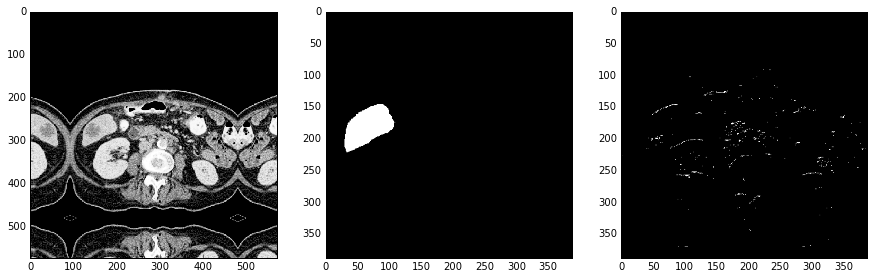

In [8]:
imshow(blobs['data'].data[0,0], blobs['label'].data[0,0], np.argmax(blobs['score'].data[0],axis=0))

In [9]:
solver.test_nets[0].forward()

{'accuracy': array(0.9507798552513123, dtype=float32),
 'prob': array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          ..., 
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
          [ 1.,  1.,  1., ...,  1.,  1.,  1.],
          [ 1.,  1.,  1., ...,  1.,  1.,  1.],
          ..., 
          [ 1.,  1.,  1., ...,  1.,  1.,  1.],
          [ 1.,  1.,  1., ...,  1.,  1.,  1.],
          [ 1.,  1.,  1., ...,  1.,  1.,  1.]]]], dtype=float32)}

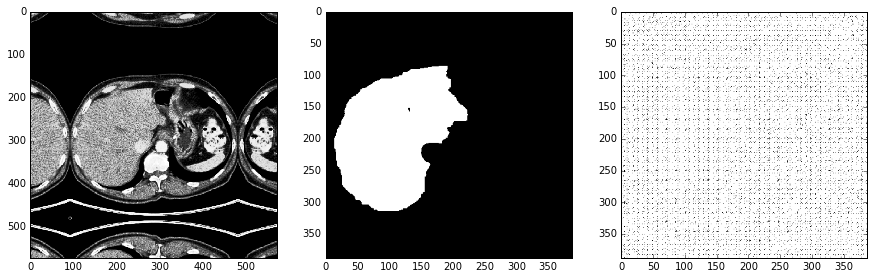

In [10]:
imshow(testblobs['data'].data[0,0], testblobs['label'].data[0,0], np.argmax(testblobs['score'].data[0],axis=0))

In [11]:
dices = []
losses= []
accuracies=[]
iterations=[]
test_dices=[]
test_accuracies=[]
i = 0

In [12]:
PLOT_INTERVAL = 100
# In case of resumed training, make sure all lists have equal size. Since kernel interruption might cause them to be 
# not equal
print len(iterations),len(dices),len(losses),len(accuracies),len(iterations),len(test_dices),len(test_accuracies)
min_len=min(len(iterations),len(dices),len(losses),len(accuracies),len(iterations),len(test_dices),len(test_accuracies))
min_len -= min_len%PLOT_INTERVAL
i -= i%PLOT_INTERVAL
print 'i',i
print "Min len",min_len
dices = dices[:min_len]
losses= losses[:min_len]
accuracies=accuracies[:min_len]
iterations=iterations[:min_len]
test_dices=test_dices[:min_len]
test_accuracies=test_accuracies[:min_len]
print len(iterations),len(dices),len(losses),len(accuracies),len(iterations),len(test_dices),len(test_accuracies)
print i

0 0 0 0 0 0 0
i 0
Min len 0
0 0 0 0 0 0 0
0


In [ ]:
def smooth_last_n(arr, n=5):
    """Replaces the last n elements in arr (list) with their average."""
    mean = np.mean(arr[-n:])
    return arr[:-n]+[mean]

while True:
    i += 1
    solver.step(1)

    # Get metrics
    img = blobs['data'].data[0,0]
    seg = blobs['label'].data[0,0]
    pred= np.argmax(blobs['score'].data[0],axis=0)
    dice_score = dice(pred,seg,1)
    accuracy_score = np.sum(seg==pred)*1.0 / seg.size
    loss = float(solver.net.blobs['loss'].data)
    
    #Save metrics values
    iterations.append(i)
    dices.append(dice_score if dice_score>-1 else 0)
    accuracies.append(accuracy_score)
    losses.append(loss)
    
    if i % PLOT_INTERVAL == 0:
        display.clear_output(wait=True)
        liver_train_dices = []
        for _ in range(PLOT_INTERVAL):
            test_accuracy_score=float(solver.test_nets[0].forward()['accuracy'])
            test_img = testblobs['data'].data[0,0]
            test_seg = testblobs['label'].data[0,0]
            test_pred= np.argmax(testblobs['score'].data[0], axis=0)

            test_dice_score = dice(test_pred, test_seg, 1)
            #test_accuracy_score = np.sum(test_seg==test_pred)*1.0 / test_seg.size

            test_dices.append(test_dice_score if test_dice_score > -1 else 0)
            test_accuracies.append(test_accuracy_score)
            
        
        
        # Smooth
        iterations = smooth_last_n(iterations,n=PLOT_INTERVAL)
        losses     = smooth_last_n(losses    ,n=PLOT_INTERVAL)
        dices      = smooth_last_n(dices     ,n=PLOT_INTERVAL)
        accuracies = smooth_last_n(accuracies,n=PLOT_INTERVAL)
        test_dices = smooth_last_n(test_dices,n=PLOT_INTERVAL)
        test_accuracies = smooth_last_n(test_accuracies,n=PLOT_INTERVAL)
        
        # Print last metrics
        print 'Loss',losses[-1]
        print 'Liver Train dice',dices[-1]
        print 'Liver Test dice', test_dices[-1]
        print '\n'
        
        # Plot
        fig, ax1=plt.subplots()
        ax2=ax1.twinx()
        ax1.set_xlabel("Iterations")
        ax1.set_ylabel("Dice/Accuracy")
        ax2.set_ylabel("Loss")
        ax1.plot(iterations, dices, label="Train Dice - Liver", color="#ADB317"); plt.hold(True) #dark yellow
        #ax1.plot(iterations, accuracies, label="Train Accuracy",color="#BC23C4"); plt.hold(True) #purple
        ax1.plot(iterations, test_dices, label="TEST Dice - Liver", color="#1C7A34"); plt.hold(True) #green
        #ax1.plot(iterations, test_accuracies, label="TEST Accuracy (ignore_label:0)",color="red"); plt.hold(True)
        ax2.plot(iterations, losses, label="Loss", color="blue"); plt.hold(True)
        leg1 = ax1.legend(loc="upper left", bbox_to_anchor=(1.15,1))
        leg2 = ax2.legend(loc="upper left", bbox_to_anchor=(1.15,0.5))
        # Make legend clearer
        for leghandle in leg1.legendHandles+leg2.legendHandles: leghandle.set_linewidth(10.0)
        plt.show()
        
        print 'Liver Train dice on last image : ', dice(pred,seg,1)
        imshow(img, seg, pred, title="TRAIN")
        print 'Liver Test dice on last image : ', dice(test_pred,test_seg,1)
        imshow(test_img, test_seg, test_pred, title="TEST")
    
    

## Get iteration with best test dice ##

In [15]:
dice_iter = zip(test_dices,iterations)
dice_iter = sorted(dice_iter, key=lambda t:t[0], reverse=True)
for ji in range(10):
    print str(ji+1)+'th best test Dice:\t',round(dice_iter[ji][0],3),'\tAt iteration:\t',dice_iter[ji][1]

1th best test Dice:	0.488 	At iteration:	96250.5
2th best test Dice:	0.483 	At iteration:	47250.5
3th best test Dice:	0.483 	At iteration:	55250.5
4th best test Dice:	0.482 	At iteration:	52950.5
5th best test Dice:	0.478 	At iteration:	66250.5
6th best test Dice:	0.477 	At iteration:	44350.5
7th best test Dice:	0.476 	At iteration:	48950.5
8th best test Dice:	0.475 	At iteration:	44850.5
9th best test Dice:	0.474 	At iteration:	150150.5
10th best test Dice:	0.472 	At iteration:	158250.5


In [332]:
# Save plots
pickle.dump(dices, open("dices.list",'w'))
pickle.dump(losses, open("losses.list",'w'))
pickle.dump(accuracies, open("accuracies.list",'w'))
pickle.dump(iterations, open("iterations.list",'w'))
pickle.dump(test_dices, open("test_dices.list",'w'))
pickle.dump(test_accuracies, open("test_accuracies.list",'w'))

In [63]:
mean = protobinary_to_array("mean.protobinary")

## Predicting Training examples ##

In [ ]:
for _ in range(20):
    solver.net.forward()
    img = (blobs['data'].data[0,0]+mean)[92:480,92:480]
    himg =histeq(img)
    seg = blobs['label'].data[0,0]
    pred= np.argmax(blobs['score'].data[0],axis=0)

    imshow_overlay_segmentation(himg,img,seg,pred)







# Predict TEST examples #

In [ ]:
for _ in range(20):
    solver.test_nets[0].forward()
    img = (testblobs['data'].data[0,0]+mean)[92:480,92:480]
    himg =histeq(img)
    seg = testblobs['label'].data[0,0]
    pred= np.argmax(testblobs['score'].data[0],axis=0)

    imshow_overlay_segmentation(himg,img,seg,pred)

# Avg Dice score over slices #

In [335]:
#dices_lesions_ = []
for _ in range(1000):
    solver.test_nets[0].forward()
    seg = solver.test_nets[0].blobs['label'].data[0,0]
    pred = solver.test_nets[0].blobs['score'].data[0].argmax(0)
    dice_lesion_ = dice(pred,seg,label_of_interest=1)

    if(dice_lesion_ > -1):
        dices_lesions_.append(dice_lesion_)
    print "Average TEST dice lesion: ", np.average(dices_lesions_)

print "FINAL Average TEST dice lesion: ", np.average(dices_lesions_)

Average TEST dice lesion:  0.557663581642
Average TEST dice lesion:  0.557608325663
Average TEST dice lesion:  0.557102280156
Average TEST dice lesion:  0.556890822189
Average TEST dice lesion:  0.556770508281
Average TEST dice lesion:  0.556861305888
Average TEST dice lesion:  0.557038988274
Average TEST dice lesion:  0.557223992322
Average TEST dice lesion:  0.557369645929
Average TEST dice lesion:  0.557246616066
Average TEST dice lesion:  0.556701337662
Average TEST dice lesion:  0.556953521436
Average TEST dice lesion:  0.5571593853
Average TEST dice lesion:  0.55710567952
Average TEST dice lesion:  0.557260844241
Average TEST dice lesion:  0.557456623217
Average TEST dice lesion:  0.557385967961
Average TEST dice lesion:  0.556838437541
Average TEST dice lesion:  0.557003570157
Average TEST dice lesion:  0.556617291348
Average TEST dice lesion:  0.556916931416
Average TEST dice lesion:  0.557007741673
Average TEST dice lesion:  0.556463257077
Average TEST dice lesion:  0.55644480

KeyboardInterrupt: 

# Avg Dice score over individual Lesions #

In [119]:
import sys
import scipy.spatial.distance
import scipy.ndimage
import scipy.ndimage.measurements
from collections import defaultdict
def dice_separate_lesions(seg,pred, plot=False):
    """Returns Avg dice of lesion structures and weight to assign to this avg dice."""
    #Ignore liver
    if np.unique(seg).size > 2:
        seg[seg==1] = 0
        seg[seg==2] = 1
    if np.unique(pred).size > 2:
        pred[pred==1] = 0
        pred[pred==2] = 1
    # First component is always background
    seg[0,0] = 0
    pred[0,0] = 0
    # Get connected components
    comps_seg, num_comps_seg = scipy.ndimage.label(seg)
    comps_pred, num_comps_pred = scipy.ndimage.label(pred)
    #print 'Found n connected components in ground truth (not including bg) :', num_comps_seg
    if plot: imshow(comps_seg, comps_pred, cmap="Spectral", title=['Components in Ground Truth','Components in Prediction'])
    # Get component centroids
    centroids_seg = scipy.ndimage.measurements.center_of_mass(seg, comps_seg, range(1, num_comps_seg+1))
    centroids_pred = scipy.ndimage.measurements.center_of_mass(pred, comps_pred, range(1, num_comps_pred+1))
    # round to nearest 2 decimals (otherwise we might have problems removing from list by-value due to fp inaccuracies)
    centroids_seg = map(lambda t:(round(t[0],2), round(t[1],2)), centroids_seg)
    centroids_pred = map(lambda t:(round(t[0],2), round(t[1],2)), centroids_pred)
    
    def plot_centroids(comps_img, centroids, title, w=5):
        centroid_img = np.ones(comps_img.shape)
        for x,y in centroids:
            centroid_img[x-w:x+w, y-w:y+w] = 0
        plt.title(title)
        plt.imshow(comps_img, cmap="Spectral"); plt.hold(True)
        plt.imshow(centroid_img,cmap="Reds",alpha=0.5)
        plt.show()
    
    
    if plot: plot_centroids(comps_seg, centroids_seg, "Centroids in Ground Truth")
    if plot: plot_centroids(comps_pred, centroids_pred, "Centroids in Prediction")
    
    #### Get Average dice ####
    def get_closest(xy, list_xy, except_at_idx):
        """Returns the index of coordinate in list_xy that is closest to xy (euclidean distance)
        example: get_closest((100,100), [(3,4), (5,9), (101,102), (9999,9999)]) = 2
        because (101,102) is the closest to (100,100).
        except_at_idx is a list of coordinate indices to ignore in list_xy"""
        closest_idx = -1
        min_dist = sys.maxint
        for i, xy_dest in enumerate(list_xy):
            if i in except_at_idx:
                continue
            dist = scipy.spatial.distance.euclidean(xy, xy_dest)
            if dist < min_dist:
                closest_idx = i
                min_dist = dist
        #print xy, map(lambda t:(round(t[0]),round(t[1])),list_xy), closest_idx
        return closest_idx
    
    dices = []
    consumed_lesions_idx = [] #indices of lesions already consumed.
    # Iterate after bg component
    for i in range(num_comps_pred):
        # Add 0 dice to false positives!
        if len(centroids_seg) == 0:
            dices.append(0)
            continue
        current_xy = centroids_pred[i]
        closest_component = get_closest(current_xy, centroids_seg, except_at_idx=consumed_lesions_idx)
        consumed_lesions_idx.append(closest_component)
        #mask out other components 
        one_lesion_pred = np.clip(comps_pred == i, 0, 1)
        one_lesion_seg = np.clip(comps_seg == closest_component, 0, 1)
        dices.append(dice(one_lesion_pred, one_lesion_seg, label_of_interest = 1))
    
    # Add 0 dice for false negatives
    if len(centroids_seg)-len(consumed_lesions_idx) > 0:
        dices.extend([0]*(len(centroids_seg)-len(consumed_lesions_idx)))

    return np.mean(dices), len(dices)

In [122]:
dices_lesions_ = []
weights = []
for _ in range(200):
    solver.test_nets[0].forward()
    seg = solver.test_nets[0].blobs['label'].data[0,0]
    pred = solver.test_nets[0].blobs['score'].data[0].argmax(0)
    dice_lesion_,weight = dice_separate_lesions(seg,pred)

    if(dice_lesion_ > -1):
        dices_lesions_.append(dice_lesion_)
        weights.append(weight)

total = np.multiply(dices_lesions_, weights)
print "Average TEST dice lesion: ", np.average(total)

Average TEST dice lesion:  0.567200644992


## Changing threshold (instead of 0.5) ##

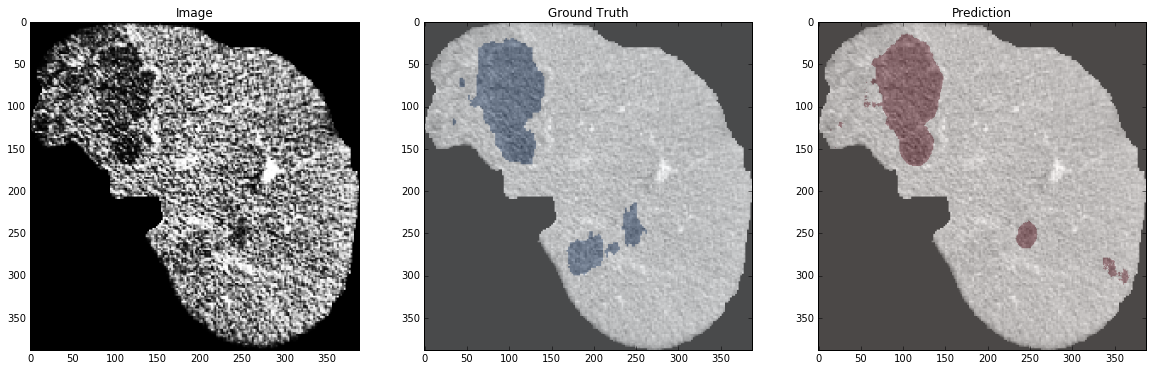

In [203]:
solver.test_nets[0].forward()
img = (testblobs['data'].data[0,0]+mean)[92:480,92:480]
himg =histeq(img)
seg = testblobs['label'].data[0,0]
pred= np.argmax(testblobs['score'].data[0],axis=0)
imshow_overlay_segmentation(himg,img,seg,pred)

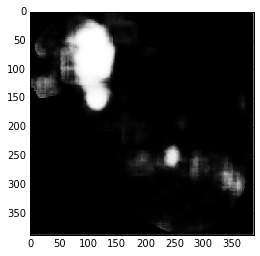

0.761515922955
0.755064840373


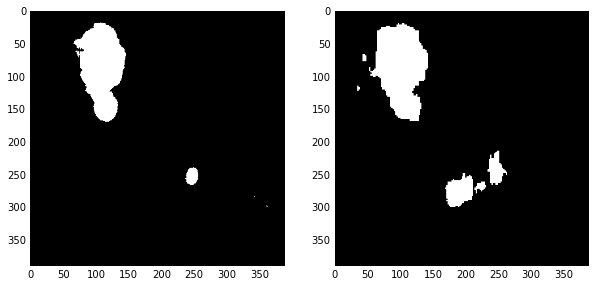

In [205]:
prob = testblobs['prob'].data[0,1]
imshow(prob)
pred_t = prob>0.7
print dice(seg,pred)
print dice(seg,pred_t)
imshow(pred_t,seg)
#prob[np.logical_and(prob>0.4, prob<0.6)].size*1.0/prob.size


#imshow_overlay_segmentation(himg,img,seg,pred)

Found max dice at threshold : 0.820512820513
Found max dice score : 0.718168875152
Vs. the dice at 0.5 which equals : 0.664054085694


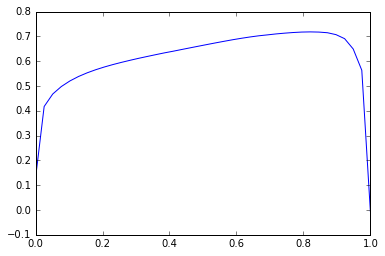

In [242]:
def softmax(a1,a2):
    s1 = np.exp(a1)
    s2 = np.exp(a2)
    sm= s1+s2
    return s1/sm , s2/sm

thresholds = np.linspace(0,1,40) #20 thresholds
dices_athalf = []
dices_bythreshold = defaultdict(list) # {0.5:[list of dices], 0.6:[list of dices]}
for _ in range(2000):
    solver.net.forward()
    img = (blobs['data'].data[0,0]+mean)[92:480,92:480]
    himg =histeq(img)
    seg = blobs['label'].data[0,0]
    prob = softmax(blobs['score'].data[0,0],blobs['score'].data[0,1])[1] #probability being a lesion
    dices_athalf.append(dice(seg,prob>0.5))
    for t in thresholds :
        pred_t = prob > t
        dice_score = dice(seg,pred_t)
        dices_bythreshold[t].append(dice_score)
        
# Aggregate dices over slices for each threshold
avgdices = []
for t in thresholds:
    avgdices.append(np.average(dices_bythreshold[t]))

plt.plot(thresholds,avgdices)
print 'Found max dice at threshold :', thresholds[np.argmax(avgdices)]
print 'Found max dice score :', np.max(avgdices)
print 'Vs. the dice at 0.5 which equals :', np.average(dices_athalf)

In [243]:
THRESHOLD = 0.820512820513
dices = []
for _ in range(2000):
    solver.test_nets[0].forward()
    img = (testblobs['data'].data[0,0]+mean)[92:480,92:480]
    seg = testblobs['label'].data[0,0]
    prob = testblobs['prob'].data[0,1] #probability being a lesion
    dice_score = dice(seg,prob> THRESHOLD)
    dices.append(dice_score)
    
print 'Average TEST threshold :', np.average(dices)

Average TEST threshold : 0.529013049811


In [247]:

dices = []
for _ in range(2000):
    solver.test_nets[0].forward()
    img = (testblobs['data'].data[0,0]+mean)[92:480,92:480]
    seg = testblobs['label'].data[0,0]
    pred = np.argmax(testblobs['prob'].data[0], axis=0) #probability being a lesion
    dice_score = dice(seg,pred)
    dices.append(dice_score)
    
print 'Average TEST threshold :', np.average(dices)

Average TEST threshold : 0.533852793774


Found max dice at threshold : 0.615384615385
Found max dice score : 0.545312007104
Vs. the dice at 0.5 which equals : 0.538774570138


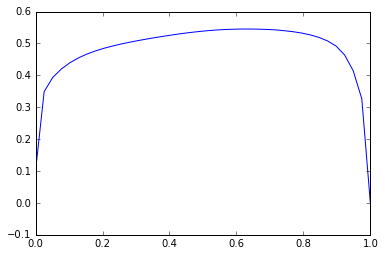

In [223]:
thresholds = np.linspace(0,1,40) #20 thresholds
dices_athalf = []
dices_bythreshold = defaultdict(list) # {0.5:[list of dices], 0.6:[list of dices]}
for _ in range(2000):
    solver.test_nets[0].forward()
    img = (testblobs['data'].data[0,0]+mean)[92:480,92:480]
    himg =histeq(img)
    seg = testblobs['label'].data[0,0]
    prob = testblobs['prob'].data[0,1] #probability being a lesion
    dices_athalf.append(dice(seg,prob>0.5))
    for t in thresholds :
        pred_t = prob > t
        dice_score = dice(seg,pred_t)
        dices_bythreshold[t].append(dice_score)
        
# Aggregate dices over slices for each threshold
avgdices = []
for t in thresholds:
    avgdices.append(np.average(dices_bythreshold[t]))

plt.plot(thresholds,avgdices)
print 'Found max dice at threshold :', thresholds[np.argmax(avgdices)]
print 'Found max dice score :', np.max(avgdices)
print 'Vs. the dice at 0.5 which equals :', np.average(dices_athalf)

# Prototxts #

In [51]:
!cat solver_unet.prototxt

# Dataset: stat-10-15-15-aug6-400-float
# 261960

#net: "phseg_v5-train.prototxt"
net: "unet-overfit.prototxt"

test_iter: 1
test_interval: 100000000

lr_policy: "step"
gamma: 0.1 # 0.0001
stepsize: 60000 # f��r batch size 40 -> 8 Epochen 
base_lr: 0.01

display: 10
max_iter: 100000000 # f��r batch size 48 -> 24 Epochenn
momentum: 0.8
weight_decay: 0

snapshot: 500
snapshot_prefix: "snapshot/"
solver_mode: GPU


In [52]:
!cat unet-overfit.prototxt

name: "phseg_v5"
force_backward: true



# Import Layer
layer {
  name: "data"
  type: "Data"
  top: "data"
  include {
    phase: TRAIN
  }
  transform_param {   mean_file: "mean.protobinary"}
  data_param {
    source: "train_img"
    batch_size: 1
    backend: LEVELDB
  }
}
layer {
  name: "label"
  type: "Data"
  top: "label"
  include {
    phase: TRAIN
  }
  data_param {
    source: "train_seg"
    batch_size: 1
    backend: LEVELDB
  }
}
layer {
  name: "data"
  type: "Data"
  top: "data"
  include {
    phase: TEST
  }
  transform_param {    mean_file: "mean.protobinary"}
  data_param {
    source: "test_img"
    batch_size: 1
    backend: LEVELDB
  }
}
layer {
  name: "label"
  type: "Data"
  top: "label"
  include {
    phase: TEST
  }
  data_param {
    source: "test_seg"
    batch_size: 1
    backend: LEVELDB
  }
}






layer {
  name: "conv_d0a-b"
  type: "Convolution"
  bottom: "data"
  top: "d0b"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
  